<a href="https://colab.research.google.com/github/tuanlamdao/datascience/blob/master/11_Hyperparameters_and_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tuanlam import *

In [ ]:
iris = datasets.load_iris()
diabetes = datasets.load_diabetes()
digits = datasets.load_digits()

#### Turning Hyperparameters

##### Evaluating a single hyperparameter

In [ ]:
knn = neighbors.KNeighborsClassifier()
print(" ".join(knn.get_params().keys()))

algorithm leaf_size metric metric_params n_jobs n_neighbors p weights


In [ ]:
param_grid = {"n_neighbors": [1,3,5,10,20]}
grid_model = skms.GridSearchCV(knn,return_train_score=True,param_grid=param_grid,cv=10)
grid_model.fit(digits.data, digits.target)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 3, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

NameError: name 'sef' is not defined

param_n_neighbors     mean_train_score      std_train_score  \
0                 1               1.0000               0.0000   
1                 3               0.9933               0.0009   
2                 5               0.9907               0.0005   
3                10               0.9861               0.0011   
4                20               0.9806               0.0018   

       mean_test_score       std_test_score  
0               0.9761               0.0180  
1               0.9777               0.0161  
2               0.9738               0.0167  
3               0.9644               0.0208  
4               0.9610               0.0233

NameError: name 'sef' is not defined

mean_train_score      mean_test_score
param_n_neighbors                                          
1                               1.0000               0.9761
3                               0.9933               0.9777
5                               0.9907               0.9738
10                              0.9861               0.9644
20                              0.9806               0.9610

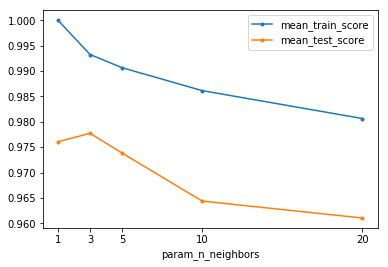

In [ ]:
param_cols = ['param_n_neighbors']
score_cols = ['mean_train_score','std_train_score','mean_test_score','std_test_score']
df = pd.DataFrame(grid_model.cv_results_).head()
display(df[param_cols + score_cols])

grid_df = pd.DataFrame(grid_model.cv_results_,columns=['param_n_neighbors','mean_train_score','mean_test_score'])
grid_df.set_index('param_n_neighbors',inplace=True)
display(grid_df)

ax = grid_df.plot.line(marker='.')
ax.set_xticks(grid_df.index)

##### Evaluating over multiple hyperparameters
example: we want to try all combinations of these hyperparameters:
Hyperparameter         values
n_neighbors            1,...,10
weights                uniform, distance
p                      1,2,4,8,16
notes: distance means my neighbors' contribution is weighted by its distance from me.
       uniform means all my neightbors are considered the same with no weighting
       p is an argument to a Minkowski distance constructor (p = 1 iw Manhatan distance (L1-like), p = 2 is Euclidean distance (L2-like) and higher 
       ps approach something called an infinity-norm  

In [ ]:
param_grid = {"n_neighbors": np.arange(1,11), "weights": ['uniform','distance'],"p": [1,2,4,8,16]}
knn = neighbors.KNeighborsClassifier()
grid_model = skms.GridSearchCV(knn, param_grid = param_grid, cv=10)

This code will take a bit longer than our previous, because we are fiting 10 x 2 x 5 x 10 = 200 total models 

In [ ]:
%timeit -r1 grid_model.fit(iris.data,iris.target)

5.14 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
param_df = pd.DataFrame.from_records(grid_model.cv_results_['params'])
param_df['mean_test_score'] = grid_model.cv_results_['mean_test_score']
param_df.sort_values(by=['mean_test_score']).tail()

NameError: name 'sef' is not defined

n_neighbors   p   weights      mean_test_score
79            8  16  distance               0.9800
78            8  16   uniform               0.9800
77            8   8  distance               0.9800
88            9  16   uniform               0.9800
99           10  16  distance               0.9800

In [ ]:
print("Best Estimator:", grid_model.best_estimator_, "Best Score:", grid_model.best_score_,"Best Params:", grid_model.best_params_, sep="\n")

Best Estimator:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=4,
           weights='uniform')
Best Score:
0.98
Best Params:
{'n_neighbors': 8, 'p': 4, 'weights': 'uniform'}


##### Using Randomness to search for a needle in a haystack
if we have many hyperparameters, or if the range of possible values for a single hyperparameter is large, we may not be able to exhaustively try all possibilities. In these scenarios, we can specify random combinations of the hyperparameters 

In [ ]:
import scipy.stats as ss
knn = neighbors.KNeighborsClassifier()
param_dists = {"n_neighbors" : ss.randint(1,11), "weights" : ['uniform','distance'], "p" : ss.geom(p=.5)}
mod = skms.RandomizedSearchCV(knn, param_distributions = param_dists, cv=10, n_iter=20)
%timeit -r1 mod.fit(iris.data, iris.target)
print(mod.best_score_)

710 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
0.98


##### Cross validation nested with Cross validation
we used 5-fold repeats of 3-fold cross-validation for a 5 x 3 nested cross-validation strategy

In [ ]:
param_grid = {"n_neighbors" : np.arange(1,11), "weights" : ['uniform','distance'], "p" : [1,2,4,8,16]}
knn = neighbors.KNeighborsClassifier()
grid_knn = skms.GridSearchCV(knn, param_grid = param_grid, cv=3 )
outer_scores = skms.cross_val_score(grid_knn, iris.data, iris.target, cv=5)
print(outer_scores)

[0.9667 1.     0.9333 0.9667 1.    ]


#### Pipeline

##### A simple pipeline
create a pipeline of learning components from multiple models and transformers and then use that pipeline as a model. make_pipeline turns this into a one-liner

In [ ]:
scaler = skpre.StandardScaler()
logreg = linear_model.LogisticRegression()
pipe = pipeline.make_pipeline(scaler, logreg)
print(skms.cross_val_score(pipe, iris.data, iris.target, cv=10))

[0.8    0.8667 1.     0.8667 0.9333 0.9333 0.8    0.8667 0.9333 1.    ]


##### A more complex pipeline
As we add more steps to a learning task, we get more benefits from using a pipeline. Let's use an example where we have four major processing steps:
1. Standardize the data
2. Create interaction terms between the features
3. Discretize the features to big-small 
4. Apply a learning method to the resulting features


In [ ]:
from sklearn.base import TransformerMixin
class Median_Big_Small(TransformerMixin):
    def __int__(self):
        pass
    def fit(self, ftrs, tgt=None):
        self.medians = np.median(ftrs)
        return self
    def transform(self, ftrs, tgt=None):
        return ftrs > self.medians

scaler = skpre.StandardScaler()
quad_inters = skpre.PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
median_big_small = Median_Big_Small()
knn = neighbors.KNeighborsClassifier()
pipe = pipeline.Pipeline(steps=[('scaler', scaler), ('inter',quad_inters), ('mbs', median_big_small), ('knn', knn)])
cv_scores = skms.cross_val_score(pipe, iris.data, iris.target, cv=10)
print(cv_scores)


[0.6    0.7333 0.8667 0.7333 0.8667 0.7333 0.6667 0.6667 0.8    0.8   ]


##### Pipelines and turning together

In [ ]:
scaler = skpre.StandardScaler()
poly = skpre.PolynomialFeatures()
lasso = linear_model.Lasso(selection='random', tol=.01)
pipe = pipeline.make_pipeline(scaler, poly, lasso)

param_grid = {"polynomialfeatures__degree" : np.arange(2,6), "lasso__alpha" : np.logspace(1,6,6,base=2)}
from pprint import pprint as pp
pp(param_grid)

{'lasso__alpha': np.array([2., 4., 8., 16., 32., 64.]), 'polynomialfeatures__degree': np.array([2,3,4,5])}

mod = skms.GridSearchCV(pipe, param_grid, iid=False, n_jobs=-1)
mod.fit(diabetes.data, diabetes.target)

for name, step in mod.best_estimator_.named_steps.items():
    print("step:", name)
    print(textwrap.indent(textwrap.fill(str(step),50)," " * 6))
    

{'lasso__alpha': array([ 2.,  4.,  8., 16., 32., 64.]),
 'polynomialfeatures__degree': array([2, 3, 4, 5])}
step: standardscaler
      StandardScaler(copy=True, with_mean=True,
      with_std=True)
step: polynomialfeatures
      PolynomialFeatures(degree=2, include_bias=True,
      interaction_only=False)
step: lasso
      Lasso(alpha=4.0, copy_X=True, fit_intercept=True,
      max_iter=1000,    normalize=False, positive=False,
      precompute=False, random_state=None,
      selection='random', tol=0.01, warm_start=False)


we are only really interested in the best values for parameters we were considering:

In [ ]:
pp(mod.best_params_)

{'lasso__alpha': 4.0, 'polynomialfeatures__degree': 2}


Summary: we now solved two of the remaining issues in building larger learning systems. First, we can buld system with multiple , modular components working together. Second, we can systematically evaluate hyperparameters and select the good ones. we can do that eavaluation in a non-teaching-to-the-test maner